# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [30]:
#note: this needs to be ran when starting the notebook each time.
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached funcy-1.18-py2.py3-none-any.whl (33 kB)
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=5118dc4c0b4f36fef295e48f260e02b8bc150758182b33ddc03e6b99bfdebbcc
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=9c0338c206825516dc1cb70d9f27ce33ed91267794eb01663b21064d09b5dc22
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Succ

In [31]:
# These libraries may be useful to you
import nltk 
nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [32]:
# add any additional libaries you need here
from nltk.corpus import brown as brown

In [33]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [34]:
# categories of articles in Brown corpus
all_brown_cat = []
for category in brown.categories() :
  all_brown_cat.append(category)
  print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [35]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [36]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

#view contents of the df
df.head()

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


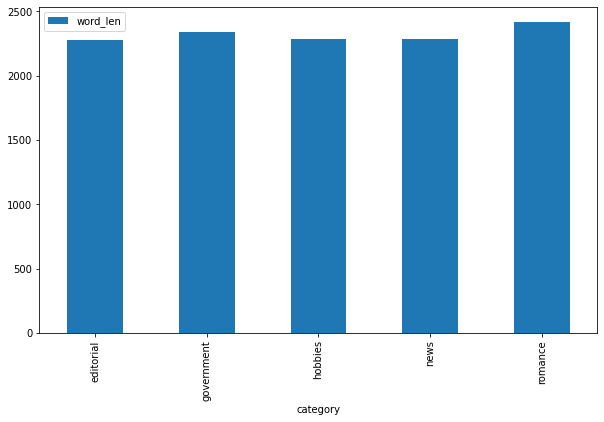

In [37]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [38]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [39]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [40]:
count_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

In [41]:
tfidf_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.float64'>'
	with 72541 stored elements in Compressed Sparse Row format>

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A:
* `count_text_vectors`:  This is a sparse matrix where each row is a document, and each column in a word, where the the frequency of each word in each document is counted. Stop words are removed from this matrix. 

* `tfidf_text_vectors`:  This is a term frequency-inverse document frequency of each word in each document. This value is a a weight that is assigned to each word that takes into account both the frequency that the word appears within the text and within the entirety of the corpus. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [44]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [45]:
#display the topics produced by NMF model
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [47]:
#show the original brown categories the data frame
print(df.category.unique())

['editorial' 'government' 'news' 'romance' 'hobbies']


In [48]:
#create a dictionary to map topics to categories
topic_to_category = {}

#iterate over the topics in the NMF model
for topic_id, topic in enumerate(W_text_matrix.T):
    most_relevant_docs = np.argsort(topic)[::-1][:5]
    categories = [df.iloc[doc_idx]['category'] for doc_idx in most_relevant_docs]
    topic_to_category[topic_id] = Counter(categories)

#print the topics and the categories they are associated with
for topic_id, category_counts in topic_to_category.items():
    print("Topic %d:" % topic_id)
    for category, count in category_counts.items():
        print("  %s: %d" % (category, count))

Topic 0:
  editorial: 2
  news: 3
Topic 1:
  romance: 5
Topic 2:
  government: 4
  news: 1
Topic 3:
  news: 5
Topic 4:
  news: 5


Q: How does your five-topic NMF model compare to the original Brown categories? 


### Overview of Comparison of NMF model to original Brown categories:

* Topic 00 topics produced by the NMF model include:  mr, president, kennedy, united, and hrushchev. Comparing back to the Brown corpus, the categories suggest editorial and news. 

* Topic 01 topics produced by the NMF model include:  said, didn, ll, thought man. Comparing back to the Brown corpus, the categories suggest romance. 

* Topic 02 topics produced by the NMF model include:  state, development, sales, tax, program. Comparing back to the Brown corpus, the categories suggest government and news. 

* Topic 03 topics produced by the NMF model include:  mrs, mr, said, miss, car. Comoparing back to the Bronw corpus, the categories suggest news. 

* Topic 04 topics produced by the NMF model include:  game, league, ball, baseball, team. Comparing back to the Brown coprus, the categories suggest news. 

### Summation:
Topics 00 and 02 appear to clearly relate to an editorial and a government context. Topics 01, 03, and 04 are less apparent, as without knowledge of what the categories "should" be, I would likely not associate the topics from the NMF model to the categories within the Brown corpus. This is especially the case for Topic 01, where said, didn, ll, thought and man (generally incoherent results) are related to Romance, and Topic 04 being related to News, whereas I likely would have placed that into a baseball/hobby category, unless I knew the corpus from which I was drawing the data from was "News" but from a sports perspective, or the time range associtaed with the news was during the World Series. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [49]:
#create a topic model with Latent Semantic Analysis (LSA), SVD(singular value decomposition)
svd_text_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [50]:
#display the feature names within the SVD
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


In [51]:
#create a dictionary to map topics to categories
topic_to_category = {}

#iterate over the topics in the SVD model
for topic_idx, topic in enumerate(W_svd_text_matrix.T):
    most_relevant_docs = np.argsort(topic)[::-1][:5]
    categories = [df.iloc[doc_idx]['category'] for doc_idx in most_relevant_docs]
    topic_to_category[topic_idx] = Counter(categories)

#print the topics and the categories they are associated with
for topic_idx, category_counts in topic_to_category.items():
    print("Topic %d:" % topic_idx)
    for category, count in category_counts.items():
        print("  %s: %d" % (category, count))

Topic 0:
  news: 4
  romance: 1
Topic 1:
  romance: 5
Topic 2:
  news: 5
Topic 3:
  news: 5
Topic 4:
  news: 5


Q: How does your five-topic LSA model compare to the original Brown categories? 

* Topic 00 topics produced by the SVD model include:  said, mr, mrs, state man. Comparing back to the Brown corpus, the categories suggest news and romance. 

* Topic 01 topics produced by the SVD model include:  said, didn, ll, thought got. Comparing back to the Brown corpus, the categories suggest romance. 

* Topic 02 topics produced by the SVD model include:  mrs, mr, said, kennedy, khrushchev. Comparing back to the Brown corpus, the categories suggest news. 

* Topic 03 topics produced by the SVD model include:  mrs, club, game, jr, university. Comparing back to the Brown corpus, the categories suggest news. 

* Topic 04 topics produced by the SVD model include:  game, league, baseball, ball, team. Comparing back to the Brown coprus, the categories suggest news. 

Q: What is your interpretation of the display topics output? 

A: Immediately, it is apparent that the news category in the Brown corpus is overwhelmingly abundent when comparing back to the SVD model. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [53]:
#Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [54]:
#Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

What immediatlely differentiates the LDA model from the others, is that the words it is producing are more unique relative to the NMF and SVD models. There is less overlap of the same words (mr, mrs especially) and the words, when looked at holistically by topic, make more sense intuitively as a group. Where a few of the topics produced in both the NMF and SVD models are generally incoherient, the LDA model does not have this same issue, and all 5 of the topics produced could be used as some type of category. 


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

In [55]:
#create a dictionary to map topics to categories
topic_to_category = {}

#iterate over the topics in the NMF model
for topic_idx, topic in enumerate(W_lda_text_matrix.T):
    most_relevant_docs = np.argsort(topic)[::-1][:5]
    categories = [df.iloc[doc_idx]['category'] for doc_idx in most_relevant_docs]
    topic_to_category[topic_idx] = Counter(categories)

#print the topics and the categories they are associated with
for topic_idx, category_counts in topic_to_category.items():
    print("Topic %d:" % topic_idx)
    for category, count in category_counts.items():
        print("  %s: %d" % (category, count))

Topic 0:
  hobbies: 1
  romance: 4
Topic 1:
  government: 5
Topic 2:
  news: 3
  government: 1
  editorial: 1
Topic 3:
  hobbies: 4
  news: 1
Topic 4:
  government: 5


The LDA model, while still having some topics that have multiple categories from the Brown corpus listed, does a better job at finding the uniquness contained within the original Brown corpus compaired to the NMF and SVD models. 

In [56]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [57]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

First, there is no overlap for any topics within the Intertopic Distance Map. With the exception topics 2 and 4, the topics generally far from one another (in two dimensions). This translates to topics 2 and 4 being more similar to one another than other topics. When looking at the individual word distributions within 2 and 4 however, no word overlap is observed. 

Topic 3 is the most pronounced topic, as the red bars, representing the word distributions are decrease very quickly.

Topics 1, 2 and 5 are moderatly pronounced, as the red bars, representing the word distributions are decrease, but not at the same rate as Topic 3. 

Lastly, Topic 4 is the least pronounced, as when looking at the red bars, the bars are not decreaseing quickly. 
